In [1200]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log

In [1201]:
START_DATE = datetime.date(2020,2,24)

In [1202]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [1203]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_regione"]==region]["totale_casi"].sum())
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [1204]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    print("Doubling time:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    return

In [1205]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    return (5*log(2))/(log(cases_df_today/cases_df_five_days_ago))
    

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 587
New cases registered today: 58
Doubling time: 3.7
Trend of new cases (in %) in the last 5 days: 156.33


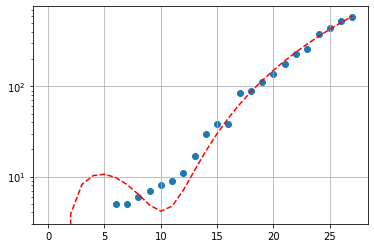

In [1206]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases up to today: 102
New cases registered today: 11
Doubling time: 3.8
Trend of new cases (in %) in the last 5 days: 148.78


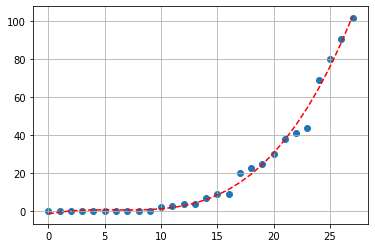

In [1207]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

Total cases up to today: 38
New cases registered today: 7
Doubling time: 5.0
Trend of new cases (in %) in the last 5 days: 100.0


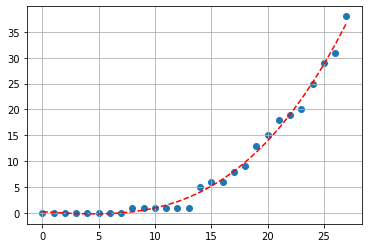

In [1208]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

Total cases up to today: 334
New cases registered today: 32
Doubling time: 3.9
Trend of new cases (in %) in the last 5 days: 142.03


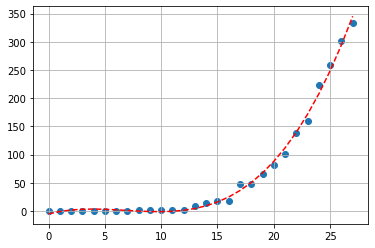

In [1209]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

Total cases up to today: 113
New cases registered today: 8
Doubling time: 2.7
Trend of new cases (in %) in the last 5 days: 264.52


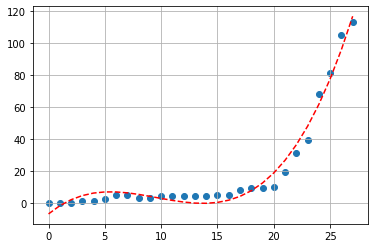

In [1210]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 81
New cases registered today: 15
Doubling time: 2.5
Trend of new cases (in %) in the last 5 days: 305.0


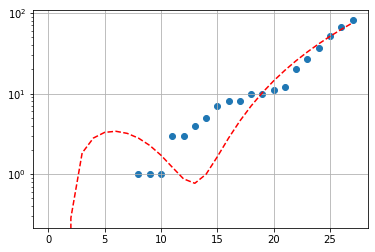

In [1211]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases up to today: 16
New cases registered today: 8
Doubling time: 2.5
Trend of new cases (in %) in the last 5 days: 300.0


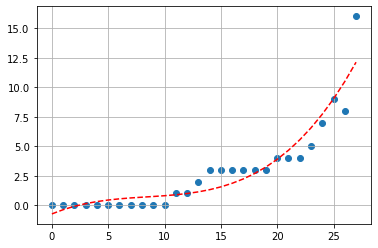

In [1212]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases up to today: 65
New cases registered today: 7
Doubling time: 2.5
Trend of new cases (in %) in the last 5 days: 306.25


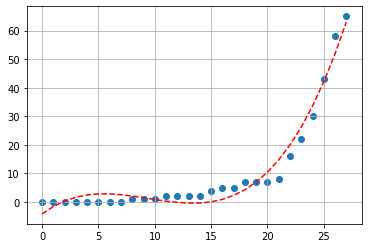

In [1213]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 678
New cases registered today: 57
Doubling time: 4.1
Trend of new cases (in %) in the last 5 days: 132.99


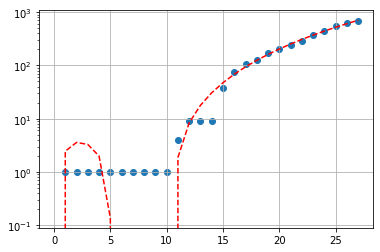

In [1214]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 273
New cases registered today: 38
Doubling time: 4.0
Trend of new cases (in %) in the last 5 days: 139.47


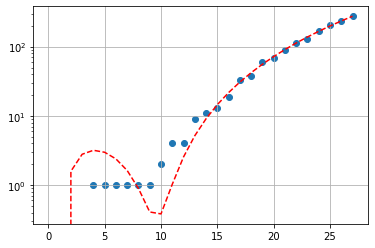

In [1215]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases up to today: 45
New cases registered today: 7
Doubling time: 3.0
Trend of new cases (in %) in the last 5 days: 221.43


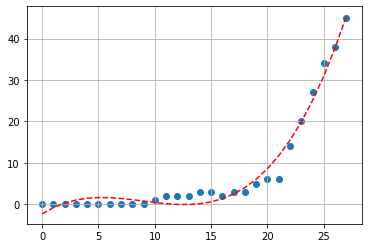

In [1216]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases up to today: 63
New cases registered today: 13
Doubling time: 4.1
Trend of new cases (in %) in the last 5 days: 133.33


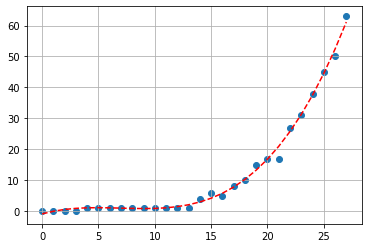

In [1217]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases up to today: 61
New cases registered today: 11
Doubling time: 3.3
Trend of new cases (in %) in the last 5 days: 190.48


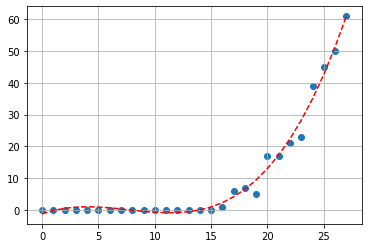

In [1218]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases up to today: 88
New cases registered today: 4
Doubling time: 5.3
Trend of new cases (in %) in the last 5 days: 91.3


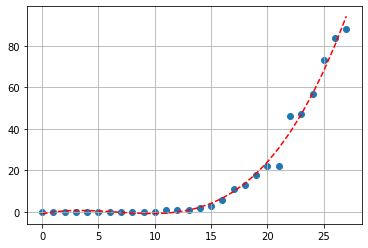

In [1219]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases up to today: 14
New cases registered today: 3
Doubling time: 4.1
Trend of new cases (in %) in the last 5 days: 133.33


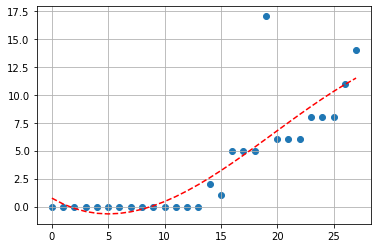

In [1220]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 936
New cases registered today: 92
Doubling time: 4.9
Trend of new cases (in %) in the last 5 days: 103.48


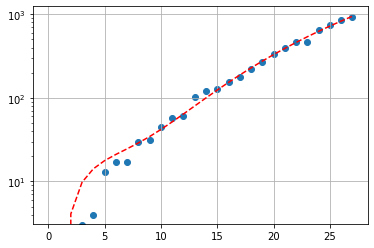

In [1221]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases up to today: 132
New cases registered today: 8
Doubling time: 4.0
Trend of new cases (in %) in the last 5 days: 135.71


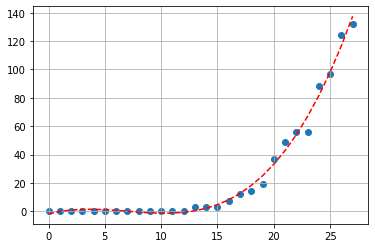

In [1222]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases up to today: 13
New cases registered today: 2
Doubling time: 2.9
Trend of new cases (in %) in the last 5 days: 225.0


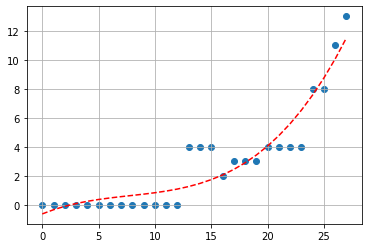

In [1223]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases up to today: 116
New cases registered today: 10
Doubling time: 6.0
Trend of new cases (in %) in the last 5 days: 78.46


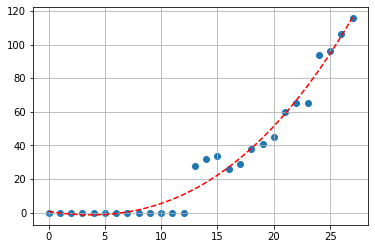

In [1224]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases up to today: 504
New cases registered today: 41
Doubling time: 5.2
Trend of new cases (in %) in the last 5 days: 95.35


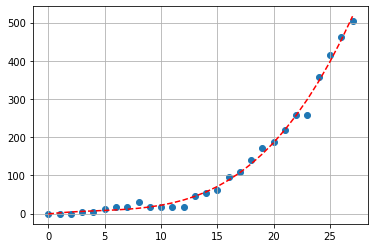

In [1225]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases up to today: 157
New cases registered today: 31
Doubling time: 3.9
Trend of new cases (in %) in the last 5 days: 141.54


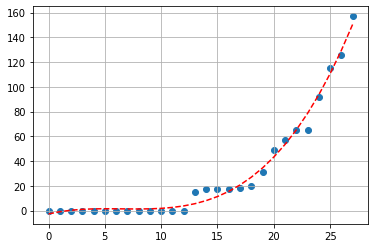

In [1226]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 7555
New cases registered today: 850
Doubling time: 5.3
Trend of new cases (in %) in the last 5 days: 92.19


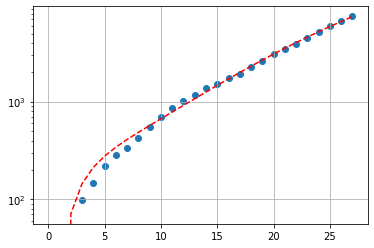

In [1227]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases up to today: 674
New cases registered today: 64
Doubling time: 4.9
Trend of new cases (in %) in the last 5 days: 102.4


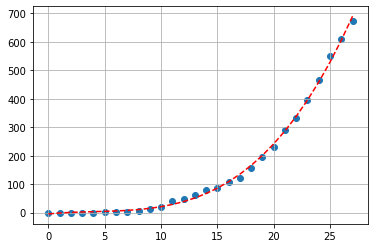

In [1228]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases up to today: 150
New cases registered today: 27
Doubling time: 3.6
Trend of new cases (in %) in the last 5 days: 158.62


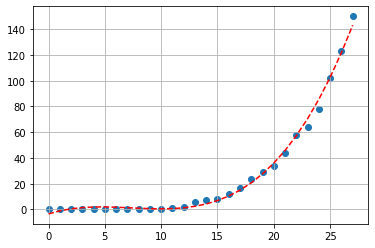

In [1229]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Forlì-Cesena

Total cases up to today: 329
New cases registered today: 60
Doubling time: 4.2
Trend of new cases (in %) in the last 5 days: 128.47


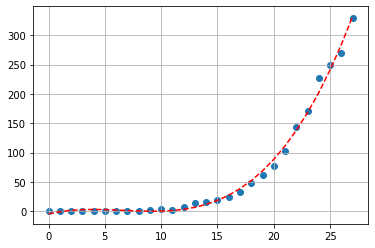

In [1230]:
calculate_and_create_chart_for_province(START_DATE, 'Forlì-Cesena')

## Modena

Total cases up to today: 1010
New cases registered today: 104
Doubling time: 4.4
Trend of new cases (in %) in the last 5 days: 119.57


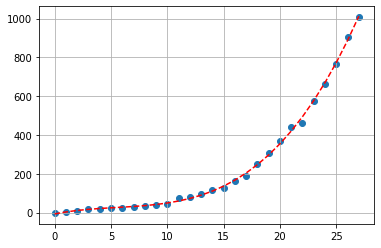

In [1231]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases up to today: 1209
New cases registered today: 195
Doubling time: 8.4
Trend of new cases (in %) in the last 5 days: 51.12


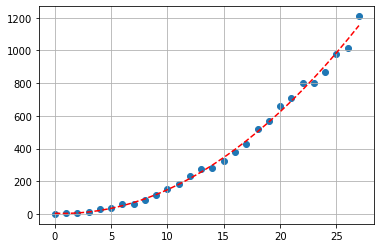

In [1232]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases up to today: 1765
New cases registered today: 72
Doubling time: 9.1
Trend of new cases (in %) in the last 5 days: 46.59


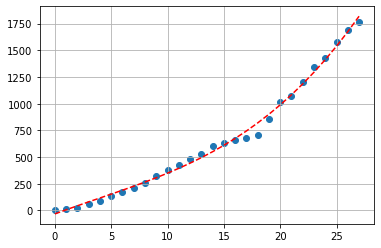

In [1233]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases up to today: 309
New cases registered today: 22
Doubling time: 3.8
Trend of new cases (in %) in the last 5 days: 149.19


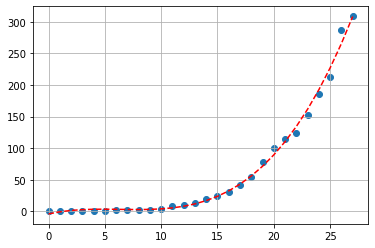

In [1234]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases up to today: 1167
New cases registered today: 190
Doubling time: 2.5
Trend of new cases (in %) in the last 5 days: 290.3


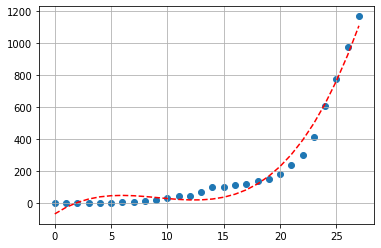

In [1235]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases up to today: 942
New cases registered today: 116
Doubling time: 5.6
Trend of new cases (in %) in the last 5 days: 85.07


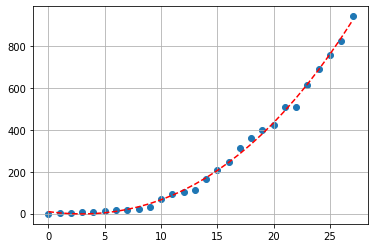

In [1236]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 874
New cases registered today: 84
Doubling time: 4.3
Trend of new cases (in %) in the last 5 days: 121.83


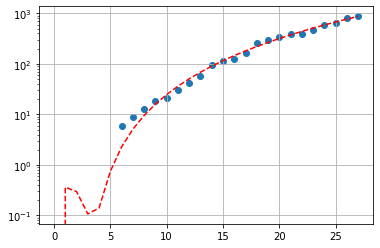

In [1237]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases up to today: 44
New cases registered today: 6
Doubling time: 3.9
Trend of new cases (in %) in the last 5 days: 144.44


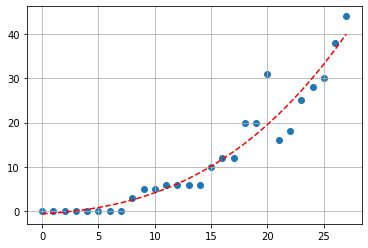

In [1238]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi in Veneto

In [ ]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Padova

In [ ]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')